# PreProcessing Notebook

The notebook was used for peak detection and data exploration.

- Categorizes key press data
- Creates output for the Processing notebook
- Builds video showing key presses with overlayed text

## Imports

In [23]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline
import pandas as pd
import numpy as np
import sys, os, time, datetime
import matplotlib.pyplot as plt


sys.path.append('Libraries')
import signal_processing as spl 
spl = reload(spl)

ERROR! Session/line number was not unique in database. History logging moved to new session 1083


## File of Raw Recording (.m4a, .wav, whatever) and text input

In [24]:
# Name of the raw input file
raw_file = 'audio/perfect_dataset.wav'
name = 'perfect_dataset'

# Name of the text file associated with input
raw_text_file = 'text/perfect.txt'

# Open and print length of text in chars
text = open(raw_text_file, 'r').read()
print len(text)

3453


In [25]:
# # Name of the raw input file
# raw_file = 'audio/alice_space_slow.wav.m4a'
# name = 'alice_space_slow'

#  # Name of the text file associated with input
# raw_text_file = 'text/alice_space_slow.txt'

# # Open and print length of text in chars
# text = open(raw_text_file, 'r').read()
# print len(text)

## Read in the true times that peaks occured or manually add 

In [26]:
if name == 'perfect_dataset':
    BAD_INDS = []
    TO_ADD = []
    
    true_results = pd.read_csv('data/perfect_out.csv')#, index_col=0)
    true_results = true_results[true_results['letter'] != 'none'].reset_index()
    true_results.head()

elif name == 'alice_space_slow':
    
    true_results = None

    TO_ADD  = [23.18, 60.939999999999998, 82.432, 91.161333333333332, 103.374, 109.70666666666666, 126.69333333333333, 137.49199999999999,
             153.172, 153.20466666666667, 176.66399999999999, 189.94533333333334, 198.05600000000001, 227.11066666666667,
             254.91, 256.31, 256.58533333333332, 260.74799999999999, 267.03399999999999,400.68733333333336, 476.642,477.37466666666666, 488.59800000000001,
             496.69, 498.83666666666664, 506., 522.76733333333334, 537.73800000000006, 541.10266666666666, 550.27733333333333,
             559.89066666666668, 560.50199999999995, 571.39400000000001, 594.62933333333331,
             596.10400000000004, 596.22066666666672]

    BAD_INDS = [80,130,135, 159,161, 183, 197, 230, 243, 270, 299, 311, 318, 342, 343, 345, 356, 380, 414, 424, 
                553, 557, 627, 669, 685, 736, 759, 762,775,809, 820, 826, 942, 944, 978, 993, 995, 1025,1030, 1042, 1049,
               1053, 1064, 1076]


,index,Unnamed: 0,letter,ind,time
0,0,0,a,0,1.872109
1,1,1,l,1,2.237761
2,2,2,i,2,2.592897
3,3,3,c,3,2.877419
4,4,4,e,4,3.110680


## Parameters

In [41]:
# Maximum threshold to keep a signal
MAX_THRESH = 80.

# Minimum threshold to keep a signal
MIN_THRESH = 0.009

# Minimum distance apart to keep two keys
MIN_DIST = 29

# The length of a keystroke in milliseconds
KEY_LEN = 350

# Whether or not to print out
VERBOSE = True

# The minimum frequency to keep for fourier
MIN_FREQ = 400

# The maximum frequency to keep for fourier
MAX_FREQ = 12000

# KEY_LEN * BACK_PROP of key is before peak, (1-BACK_PROP) * KEY_LEN after peak
BACK_PROP = .1

# Min timepoint to analyze
MINT = 0.0

# Max timepoint to analyze
MAXT = None

# Figure plot size
FIGSZ = (16,8)

## Get raw signal

.wav file location: audio/perfect_dataset.wav
rate: 44100 measurements per second
length of audio: 1211.24569161 seconds
rate * length =  53415936 measurements


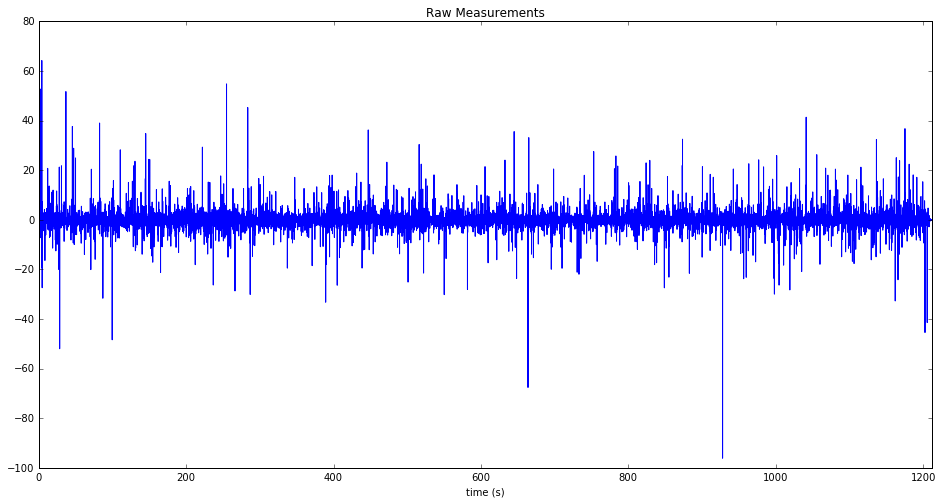

In [42]:
signal_df, rate, wav_file = spl.open_audio(raw_file, verbose = VERBOSE,
                                           plt_every = 2**8, figsz = FIGSZ)
    
if not MAXT:
    MAXT = signal_df.index[-1]

## Compute the windowed discrete-time Fourier transform of a signal using a sliding window

freqs.shape (129,) min: 0.0 max 22050.0


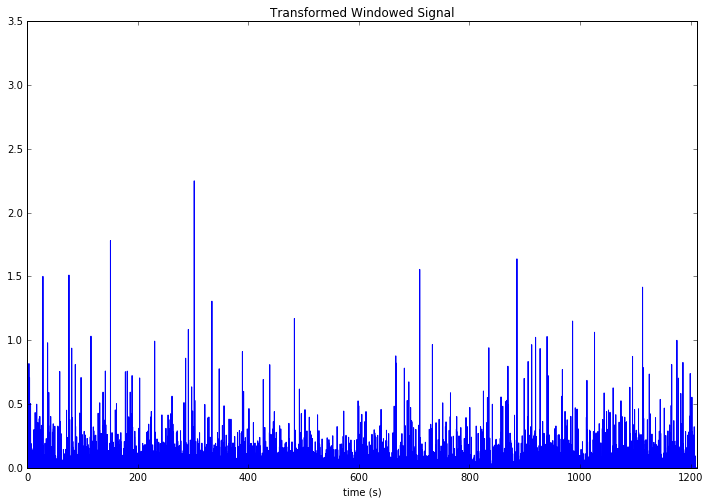

In [43]:
freqs, fourier_df = spl.get_windowed_fourier(signal_df, rate, MIN_FREQ = MIN_FREQ, 
                                             MAX_FREQ = MAX_FREQ, verbose = VERBOSE)

## Detect Peaks

Number of Keys detected: 3246


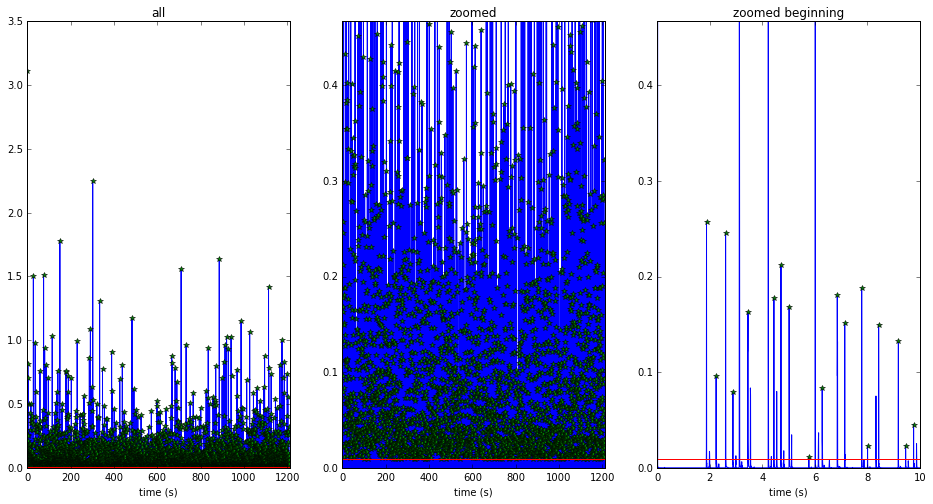

In [44]:
spl = reload(spl)
sfourier_df, ssignal_df, all_peaks = spl.detect_peaks(fourier_df, signal_df, 
                                                      t0 = MINT, t1 = MAXT , min_thresh = MIN_THRESH,
                                                      max_thresh = MAX_THRESH, min_dist = MIN_DIST, 
                                                      key_len = KEY_LEN, back_prop = BACK_PROP, 
                                                      figsz = FIGSZ, to_add = TO_ADD)

## Build peaks dataframe of the true peaks

In [45]:
true_peaks= true_results[['letter', ' time']].copy()
true_peaks['peak time'] = true_peaks[' time']
true_peaks['char'] = true_peaks['letter']
true_peaks = true_peaks.drop(['letter', ' time'],axis=1)
key_len_in_sec = KEY_LEN / 1000.
true_peaks['start time'] = true_peaks['peak time'] - BACK_PROP * key_len_in_sec
true_peaks['end time'] = true_peaks['peak time'] + (1 - BACK_PROP) * key_len_in_sec
true_peaks['signal'] = true_peaks['peak time'].map(lambda t: sfourier_df.ix[sfourier_df.iloc[np.abs(sfourier_df.index-t).argsort()[0]].name]['signal'])
true_peaks.tail()

,peak time,char,start time,end time,signal
3448,1206.603440,a,1206.568440,1206.918440,0.000746
3449,1206.880633,g,1206.845633,1207.195633,0.000116
3450,1207.134864,a,1207.099864,1207.449864,0.000007
3451,1207.493027,i,1207.458027,1207.808027,0.000004
3452,1207.817996,n,1207.782996,1208.132996,0.030487


## Map chars to the predicted peaks dataframe

In [48]:
if all_peaks.shape[0] > len(list(text)):
    all_peaks['char'] = ''
    all_peaks['char'].iloc[:len(list(text))] = list(text)
else:
    all_peaks['char'] = list(text[:all_peaks.shape[0]])
all_peaks.tail()

,peak time,signal,start time,end time,char
3241,1206.829569,0.043341,1206.794569,1207.144569,t
3242,1207.428934,0.020385,1207.393934,1207.743934,
3243,1207.586395,0.058978,1207.551395,1207.901395,a
3244,1207.820045,0.030487,1207.785045,1208.135045,n
3245,1208.515918,0.092876,1208.480918,1208.830918,d


## Build the input for processing notebook

In [60]:
def build_input(pks_df):
    starts=  pks_df['start time'].to_dict()
    ends = pks_df['end time'].to_dict()
    lent= len(signal_df.ix[(signal_df.index >= starts[0]) & (signal_df.index <= ends[0]), 'signal'].values) - 1
    
    helper = lambda x : signal_df.ix[(signal_df.index >= starts[x]) & (signal_df.index <= ends[x]), 'signal'][:lent]
    inputs = map(helper, range(pks_df.shape[0]))
    CHARACTER_INPUTS = pd.concat([pks_df, pd.DataFrame(map(lambda x : x.reset_index(drop=True), inputs)).reset_index(drop=True)], axis = 1)
    return CHARACTER_INPUTS

# Using the true peaks
ML_INPUT = build_input(true_peaks)
ML_INPUT.head()

,peak time,char,start time,end time,signal,0,1,2,3,4,...,15425,15426,15427,15428,15429,15430,15431,15432,15433,15434
0,1.872109,a,1.837109,2.187109,0.257637,-0.012722,-0.013138,0.001015,0.010370,-0.000139,...,0.017480,0.036251,0.027913,0.027172,0.025479,0.024882,0.023608,0.014553,-0.005347,-0.013629
1,2.237761,l,2.202761,2.552761,0.096119,0.041522,0.012513,-0.011354,0.001850,-0.029351,...,0.031097,0.047915,0.031691,0.037963,0.046326,0.024485,0.000196,0.000120,0.009193,0.021033
2,2.592897,i,2.557897,2.907897,0.000984,0.009739,0.030245,0.025020,0.016346,0.015063,...,-0.069529,-0.129316,-0.432837,-0.258397,-0.291056,-0.362299,0.139748,-0.169704,-0.380242,0.060050
3,2.877419,c,2.842419,3.192419,0.078914,-0.105569,-0.092772,-0.075341,-0.071108,-0.047535,...,-0.073913,0.235936,0.932212,0.823260,0.449182,0.417130,0.152498,0.364661,0.399547,0.090881
4,3.110680,e,3.075680,3.425680,0.000017,-0.022896,-0.023939,-0.025019,-0.026187,-0.020553,...,-0.005163,-0.009249,-0.029160,-0.053789,-0.050060,-0.047457,-0.058823,-0.075051,-0.092533,-0.077030


## Save result to datafile for processing

In [120]:
ML_INPUT.to_csv('data/%s.csv' % name)

## Plot a range of signals

In [ ]:
# s,e = 596, 596.15
# sfourier_df[(sfourier_df.index > s) & (sfourier_df.index < e)]['signal'].max()
# sfourier_df[(sfourier_df.index > s) & (sfourier_df.index < e)]['signal'].argmax()
# sfourier_df[(sfourier_df.index > s) & (sfourier_df.index < e)]['signal'].plot()

## Determine Windows in subset of audio

Number of Keys detected: 3246


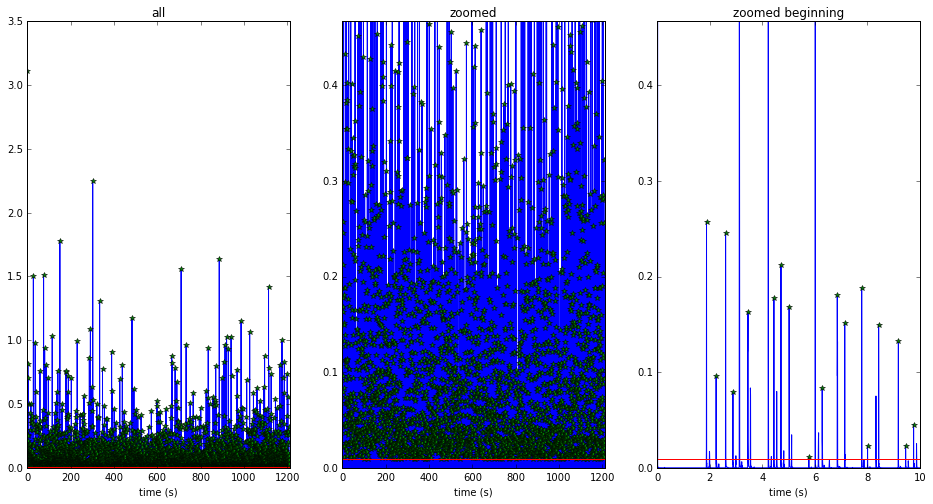

In [62]:
sfourier_df, ssignal_df, peaks = spl.detect_peaks(fourier_df, signal_df, t0 = MINT, t1 = MAXT , 
                                                 min_thresh = MIN_THRESH, max_thresh = MAX_THRESH, 
                                                  min_dist = MIN_DIST, key_len = KEY_LEN, back_prop = BACK_PROP, 
                                                  figsz = FIGSZ, to_add = TO_ADD)

In [63]:
# peaks = true_peaks.copy()

# Build Videos of Clicks

In [64]:
# Determine length of a frame in the video
_FRAME_BREAK = 20.

# Resolution of the video
MAX_FRAMES = _FRAME_BREAK * 3

# Slowdown multiplier
SLOWDOWN = 1.

### Fourier 

In [ ]:
spl = reload(spl)
outfile = spl.visualize_clicks(ssignal_df, sfourier_df, peaks, all_peaks, rate, 
                              min_thresh  = MIN_THRESH, 
                               outfile = name + '_fourier_clicks.mp4', 
                               MAX_FRAMES =MAX_FRAMES , _FRAME_BREAK = _FRAME_BREAK, 
                               SLOWDOWN = SLOWDOWN, figsz = (12,8))
outfile
spl.display_animation_from_file(outfile)

### Raw Signal

In [ ]:
spl = reload(spl)
outfile = spl.visualize_clicks(ssignal_df, ssignal_df, peaks,all_peaks, rate,  
                               min_thresh  = MIN_THRESH, outfile = name + '_signal_clicks.mp4', 
                               MAX_FRAMES = MAX_FRAMES, _FRAME_BREAK = _FRAME_BREAK, 
                               SLOWDOWN = SLOWDOWN, figsz = (12,8))
outfile
spl.display_animation_from_file(outfile)